In [1]:
from transformers import AutoModel,AutoTokenizer,BertModel
import torch
from torch import nn
import pandas as pd
import re
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from torch.optim import AdamW,Adam
import torch.nn.functional as F   
import gc
import matplotlib.pyplot as plt
from kobert_tokenizer import KoBERTTokenizer
from sklearn.metrics import accuracy_score

In [2]:
model_path = 'skt/kobert-base-v1' #multilingual

In [3]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

In [4]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.labels = list(df['label'])
        self.documents = [tokenizer(context,padding='max_length', max_length = 512, truncation=True,return_tensors="pt") for context in df['context']]

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        return {"document": self.documents[index],
                "label": self.labels[index]
                }
        
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [5]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_path)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 1024)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(1024,1)
        
    def forward(self, input_id, mask):
        last_hidden_state,_ = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout1(last_hidden_state)
        linear_output = self.linear1(dropout_output)
        dropout_output1 = self.dropout2(linear_output)
        linear_output1 = self.linear2(dropout_output1)
        sigmoid_output = F.sigmoid(linear_output1)
        return sigmoid_output[:,0,:]


In [6]:
batch_size = 16
epochs = 10
device='cuda'

In [7]:
dataset = pd.read_csv('/home/se/paper/classifier/refined_dataset.csv')

In [8]:
train,valid = train_test_split(dataset,shuffle=True)
print(len(train),len(valid))

17394 5799


In [9]:
train_dataset = ClassifierDataset(pd.DataFrame(train,columns = ['context','label']))
valid_dataset = ClassifierDataset(pd.DataFrame(valid,columns = ['context','label']))

train_class_counts = train['label'].value_counts().to_list()
train_num_samples = sum(train_class_counts)
train_labels = train['label'].to_list()

train_class_weights = [train_num_samples / train_class_counts[i] for i in range(len(train_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
train_weights = [train_class_weights[train_labels[i]] for i in range(int(train_num_samples))] #해당 레이블마다의 가중치 비율
train_sampler = WeightedRandomSampler(torch.DoubleTensor(train_weights), int(train_num_samples))

valid_class_counts = valid['label'].value_counts().to_list()
valid_num_samples = sum(valid_class_counts)
valid_labels = valid['label'].to_list()

valid_class_weights = [valid_num_samples / valid_class_counts[i] for i in range(len(valid_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
valid_weights = [valid_class_weights[valid_labels[i]] for i in range(int(valid_num_samples))] #해당 레이블마다의 가중치 비율
valid_sampler = WeightedRandomSampler(torch.DoubleTensor(valid_weights), int(valid_num_samples))

In [10]:
classifier = BertClassifier()
classifier.cuda()
optimizer = AdamW(classifier.parameters(), lr=1e-5)

In [11]:
criterion = nn.BCELoss()
criterion.cuda()

BCELoss()

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=True)

In [13]:
train_loss = []
train_acc = []

valid_loss = []
valid_acc = []

In [14]:
count = []

In [17]:
classifier.zero_grad()
for epoch in tqdm(range(epochs),total=epochs):

    total_acc_train = 0
    total_loss_train = 0
    classifier.train()
    for i,batch in enumerate(train_dataloader):

        optimizer.zero_grad()
        train_label = batch['label'].to(device)
        
        document = batch['document']
        
        mask = document['attention_mask'].to(device)
        input_id = document['input_ids'].squeeze(1).to(device)
        
        output = classifier(input_id,mask)
        output = output.squeeze(1)
        batch_loss = criterion(output.float(), train_label.float())
        batch_loss.backward()
        optimizer.step()
        
        total_loss_train += batch_loss.item()
        
        acc = (output.round() == train_label).sum().item()
        total_acc_train += acc
        
    train_loss.append(total_loss_train/ len(train_dataset))
    train_acc.append(total_acc_train/ len(train_dataset))
            
    total_acc_val = 0
    total_loss_val = 0
    classifier.eval()
    cnt = [0,0]
    with  torch.no_grad():
        for i,batch in enumerate(val_dataloader):
            
            val_label = batch['label'].to(device)
            document = batch['document']
            
            mask = document['attention_mask'].to(device)
            input_id = document['input_ids'].squeeze(1).to(device)

            output = classifier(input_id,mask)
            output = output.squeeze(1)
            batch_loss = criterion(output.float(), val_label.float())
            
            total_loss_val += batch_loss.item()
            acc = (output.round() == val_label).sum().item()
            total_acc_val += acc
            
            for value in output.round():
                cnt[int(value.item())] += 1
        count.append(cnt)
        valid_loss.append(total_loss_val/ len(valid_dataset))
        valid_acc.append(total_acc_val/ len(valid_dataset))

#       torch.save(classifier.state_dict(), './model{}.pt'.format(epoch))
 
        print(
                f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
                | Val Loss: {total_loss_val / len(valid_dataset): .3f} \
                | Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')

#             # 조기 종료 여부 확인
#         if early_stopping_step >= early_stopping_criteria:
#             break

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.019                 | Train Accuracy:  0.872                 | Val Loss:  0.021                 | Val Accuracy:  0.855
Epochs: 2 | Train Loss:  0.017                 | Train Accuracy:  0.895                 | Val Loss:  0.021                 | Val Accuracy:  0.860
Epochs: 3 | Train Loss:  0.014                 | Train Accuracy:  0.915                 | Val Loss:  0.022                 | Val Accuracy:  0.861
Epochs: 4 | Train Loss:  0.012                 | Train Accuracy:  0.933                 | Val Loss:  0.023                 | Val Accuracy:  0.852
Epochs: 5 | Train Loss:  0.010                 | Train Accuracy:  0.943                 | Val Loss:  0.023                 | Val Accuracy:  0.856
Epochs: 6 | Train Loss:  0.009                 | Train Accuracy:  0.955                 | Val Loss:  0.025                 | Val Accuracy:  0.857
Epochs: 7 | Train Loss:  0.007                 | Train Accuracy:  0.962                 | Val Loss:  0.026                 |

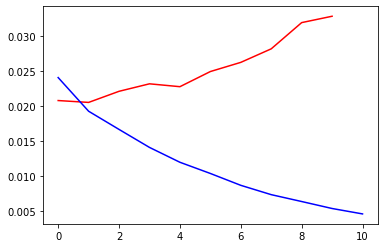

In [18]:
plt.plot(valid_loss,color='red')
plt.plot(train_loss,color='blue')
#plt.savefig('sampling_base_kobert_loss',dpi = 100)
plt.show()

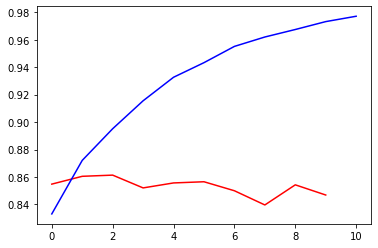

In [19]:
plt.plot(valid_acc,color='red')
plt.plot(train_acc,color='blue')
#plt.savefig('sampling_base_kobert_acc',dpi = 100)
plt.show()

In [22]:
count

[[1566, 4233],
 [1293, 4506],
 [1294, 4505],
 [1174, 4625],
 [1293, 4506],
 [1318, 4481],
 [1352, 4447],
 [1642, 4157],
 [1447, 4352],
 [1360, 4439]]

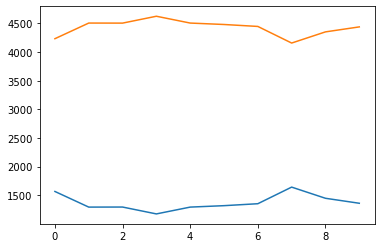

In [21]:
plt.plot(count)
plt.show()